## 0. Libraries & Dependencies

In [151]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import re
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

from typing import List, Union, Tuple
from torch import Tensor

import string

import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.notebook import tqdm

import json


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns

import random

## 1. Base functions

### 1.1 Text-processing functions

In [2]:
def tokenize_sentence(sentence: str) -> List[str]:
    """
    Tokenize a sentence (string) and returns a list of tokens (List[str])
    """
        
    return word_tokenize(sentence) 

In [3]:
def lemmatize_sentence(sentence: List[str]) -> List[str]:
    """
    Lemmatize a tokens (List[str]) and returns a list of lemme/root words (List[str])
    """    
    
    return [SnowballStemmer("english").stem(sentence[i]) for i in range(len(sentence))]

In [4]:
def remove_punctuation(strings: Union[str, List[str]]) -> List[str]:
    
    """
    Removes punctuation marks from a list of strings.

    Args:
    - List[str]: A list of strings representing tokens.

    Returns:
    - List[str]: A new list of strings with punctuation marks removed.
    """
    
    # Define a regular expression pattern for matching punctuation
    punctuation_pattern = re.compile(r'[^\w\s]|_')

    # Apply the pattern to each string in the list and replace punctuation with an empty string
    cleaned_strings = [s for s in strings if not punctuation_pattern.search(s)]

    return cleaned_strings

In [5]:
def unique_lemmatized_tokens(all_intents: List[str]) -> List[str]:
    """
    Tokenizes, lemmatizes, and removes punctuation from a list of sentences,
    returning a list of unique lemmatized tokens in a given corpus.

    Args:
    - all_intents (List[str]): A list of sentences representing different intents.

    Returns:
    - List[str]: A list of unique lemmatized tokens extracted from the input sentences.
    """
    
    all_intents_tokenized = []
    for sentences in all_intents:
        tokenized = tokenize_sentence(sentences)
        lemmatized = lemmatize_sentence(tokenized)
        cleaned = remove_punctuation(lemmatized)
        all_intents_tokenized += cleaned
    lemmatized_tokens = list(set(all_intents_tokenized))
    lemmatized_tokens.sort()
    return lemmatized_tokens

In [6]:
def generate_dataset_bag_of_words(intents_list, unique_words):
    """
    Create a bag of words representation for the given intents list and unique words.

    Parameters:
    - intents_list (dict): A dictionary containing a list of intents, where each intent has a 'patterns' field.
    - unique_words (list): A list of unique words in the vocabulary.

    Returns:
    - label (list): A list of intent labels.
    - intent_dict (dict): A dictionary mapping intent indices to their corresponding tags.
    - bag_of_words (list): A list of bag of words representations for each pattern.
    """

    labels = []
    intent_dict = {}
    bag_of_words = []

    for (idx_intent, intent) in enumerate(intents_list['intents']):
        # Access the patterns within each intent
        patterns = intent['patterns']
        tag = intent['tag']
        intent_dict[idx_intent] = tag
        labels += [idx_intent] * len(patterns)

        for (i, sentence) in enumerate(patterns):
            tokenized = tokenize_sentence(sentence)
            lemmatized = lemmatize_sentence(tokenized)
            cleaned = remove_punctuation(lemmatized)

            # Initialize a list of zeros for the bag of words representation
            pattern_bag = [0] * len(unique_words)

            for word in cleaned:
                if word in unique_words:
                    j = unique_words.index(word)
                    pattern_bag[j] += 1

            # Append the bag of words representation to the list
            bag_of_words.append(pattern_bag)
            
    bag_of_words = np.array(bag_of_words)
    
#     assert len(labels) == bag_of_words.shape[0], 'The number of labels do not match the number of patterns.'
    
    return labels, intent_dict, bag_of_words

In [7]:
def individual_bag_of_words(sentence, unique_words):
    """
    Create a bag of words representation for the given intents list and unique words.

    Parameters:
    - intents_list (dict): A dictionary containing a list of intents, where each intent has a 'patterns' field.
    - unique_words (list): A list of unique words in the vocabulary.

    Returns:
    - label (list): A list of intent labels.
    - intent_dict (dict): A dictionary mapping intent indices to their corresponding tags.
    - bag_of_words (list): A list of bag of words representations for each pattern.
    """

    tokenized = tokenize_sentence(sentence)
    lemmatized = lemmatize_sentence(tokenized)
    cleaned = remove_punctuation(lemmatized)

    # Initialize a list of zeros for the bag of words representation
    pattern_bag = [0] * len(unique_words)

    for word in cleaned:
        if word in unique_words:
            j = unique_words.index(word)
            pattern_bag[j] = 1

    individual_bag_of_words = np.array(pattern_bag)
    
#     assert len(unique_words) == individual_bag_of_words.shape[0], 'The number of labels do not match the number of patterns.'
    
    return individual_bag_of_words

In [19]:
def generate_wordcloud_from_data(data: dict, save: bool = False) -> None:
    """
    Generates a word cloud from the patterns in the given JSON data and optionally saves it as an image.

    Args:
        data (dict): JSON data containing intent patterns.
        save (bool, optional): Whether to save the word cloud as an image. Defaults to False.
    
    Returns:
        None
    """
    # Extract words from patterns
    words = []
    for intent in data["intents"]:
        words.extend(intent["patterns"])

    # Count occurrences of each word
    word_counts = Counter(words)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)

    if save:
        wordcloud.to_file("wordcloud.png")

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud")
    plt.show()

### 1.2 Neural Network related functions

In [9]:
def define_data_split(train: int, val: int, test: int):
    """Split the dataset into train, validation and test subsets"""
    
    train_idx = range(0, train)
    val_idx = range(train, train+val)
    test_idx = range(train+val, train+val+test)
    
    return train_idx, val_idx, test_idx

In [10]:
def accuracy(output, labels):
    """Compute the accuracy of the predictions"""

    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# def init_weights(m: nn.Module, init_method: Union["Xavier"]):
#     """Initialize the weights of the model"""
    
    
#     if type(m)==nn.Linear:
#         if 
#         if init_method == "Xavier":
#             nn.init.kxavier_uniform_(m.weight)
        
#         nn.init.kaiming_uniform_(m.weight)

In [40]:
def init_weights(m: nn.Module, init_method: str = 'Xavier'):
    """
    Initialize the weights of the model using a specified initialization method from PyTorch's `torch.nn.init` module.

    Args:
        m (nn.Module): The neural network module.
        init_method (str, optional): The initialization method. It must be one of "Kaimin", "Xavier", or "Trunc". Defaults is 'Xavier'.

    Returns:
        None
    """
    if init_method not in ["Kaimin", "Xavier", "Trunc"]:
        raise ValueError("init_method must be one of 'Kaimin', 'Xavier', or 'Trunc'.")
    
    if type(m)==nn.Linear:

        if init_method == "Kaimin":
            weight_init_fn = nn.init.kaiming_uniform_(m.weight)
        elif init_method == "Xavier":
            weight_init_fn = nn.init.xavier_uniform_(m.weight)
        elif init_method == "Trunc":
            weight_init_fn = nn.init.trunc_normal_(m.weight)

### 1.3 Test functions

In [12]:
def test_tokenize_sentence():

    """Description. Test for tokenize_sentence() function"""

    test_sentence = "She sings beautifully !"
    assert word_tokenize(test_sentence) == ['She', 'sings', 'beautifully', '!'], "Issue detcted with the tokenize_sentence function"


def test_lemmatize_sentence():
    """Description. Test for lemmatize_sentence() function"""
    
    tokenized_test_phrase = ['She', 'sings', 'beautifully', '!']
    
    assert [SnowballStemmer("english").stem(tokenized_test_phrase[i]) for i in range(len(tokenized_test_phrase))] == ['she', 'sing', 'beauti', '!'], "Issue detcted with the tokenize_lemmatize function"


def test_remove_punctuation():

    """Description. Test for remove_punctuation() function """

    all_punctuation = string.punctuation
    no_punctuation = remove_punctuation(all_punctuation)
    assert not no_punctuation, "The list should be empty after removing punctuation."


def test_unique_lemmatized_tokens():

    """Description. Test for unique_lemmatized_tokens() function """

    all_intents = [
        "This is a sample sentence.",
        "Another sample sentence here.",
        "Yet another example for testing."
    ]

    expected_output = [
        'a',
        'anoth', 
        'exampl', 
        'for', 
        'here', 
        'is', 
        'sampl', 
        'sentenc', 
        'test', 
        'this', 
        'yet'
    ]

    result = unique_lemmatized_tokens(all_intents)

    assert result == expected_output, "Issue detected with the unique_lemmatized_tokens function"


def test_generate_dataset_bag_of_words():

    intents_list = {
        'intents': [
            {'tag': 'greeting', 'patterns': ['Hello', 'Hi', 'Hey']},
            {'tag': 'farewell', 'patterns': ['Goodbye', 'See you', 'Hope to see you again soon']}
        ]
    }
    unique_words = ['hello', 'hi', 'hey', 'goodbye', 'see', 'you', 'hope', 'to', 'again', 'soon']

    expected_labels = [0, 0, 0, 1, 1, 1]
    expected_intent_dict = {0: 'greeting', 1: 'farewell'}
    expected_bag_of_words = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
    ])

    result_labels, result_intent_dict, result_bag_of_words = generate_dataset_bag_of_words(intents_list, unique_words)

    assert result_labels == expected_labels, 'Issue with the generation of the corpus bag of words'
    assert len(result_labels) == result_bag_of_words.shape[0] == expected_bag_of_words.shape[0], 'The number of labels do not match the number of patterns.'
    assert result_intent_dict == expected_intent_dict, 'Issue with generate_dataset_bag_of_words function'
    assert result_bag_of_words.all() == expected_bag_of_words.all(), 'Issue with generate_dataset_bag_of_words function'


def test_individual_bag_of_words():
    
    unique_words = ['hello', 'hi', 'hey', 'goodbye', 'see', 'you', 'hope', 'to', 'again', 'soon']
    test_sentence = 'Hello there, how are you'
    expected_result = np.array([
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    ])
    
    result = individual_bag_of_words(test_sentence, unique_words)
    
    assert expected_result.all() == result.all(), "Issue with the individual bag of words representation."


def test_define_data_split():
    
    expected_bag_of_words = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
    ])
    
    train, val, test = 4, 1, 1
    train_idx, val_idx, test_idx = define_data_split(train, val, test)
    assert (test_idx[-1] + 1) == expected_bag_of_words.shape[0], 'Issue with the train/val/test split'

In [13]:
def launch_test():
    print("Launching tests...")
    try:
        test_tokenize_sentence()
        test_lemmatize_sentence()
        test_remove_punctuation()
        test_unique_lemmatized_tokens()
        test_generate_dataset_bag_of_words()
        test_individual_bag_of_words()
        test_define_data_split()
        print("All tests passed successfully.")

    except AssertionError as e:
        print(f"Test failed: {e}")

In [14]:
launch_test()

Launching tests...
All tests passed successfully.


## 3. Data

### 3.1 Implementation of the database

In [168]:
data = {
    "intents": [
        {
            "tag": "greeting",
            "patterns": [
                  "Hi there",
                  "How are you",
                  "Is anyone there?",
                  "Hey",
                  "Hola",
                  "Hello",
                  "Good day",
                  "Coucou",
                  "Greetings",
                  "What's up",
                  "Yo"
            ],
          "responses": [
                "Helloooooo you",
                "Hello there",
                "Good to see you again",
                "Hi there, how can I help?",
                "Greetings! What brings you here?",
                "Hey! Ready for some Shakespearean wisdom?",
                "Hello! What can I do for you today?",
                "Hola! How may I assist you?",
                "Greetings, kind sir or madam!",
                "Yo! What's on your mind?",
                "Hi there, buddy",
                "Hi-De-Ho, old sport",
                "Hello, my friend!"
          ]
        },
        {
            "tag": "thanking",
            "patterns": [
                "Thank you",
                "Thanks a lot",
                "Thanks a million",
                "Appreciate it",
                "Much obliged",
                "You've been a great help",
                "I owe you one",
                "Grateful for your assistance",
                "I can't thank you enough",
                "You're amazing",
                "Very useful",
                "I'm so thankful"
            ],
              "responses": [
                "You're welcome!",
                "No problem!",
                "My pleasure!",
                "Happy to help!",
                "Glad I could assist!",
                "Anytime!",
                "It's what I'm here for!",
                "Don't mention it!",
                "The pleasure is mine!",
                "You're too kind!",
                "Always here for you!",
                "It was my pleasure to assist!"
                "Always a pleasure to give hand"
                "The pleasure was mine ! I remain at your disposal, should you have any further query."
              ]
        },
        {
            "tag": "farewell",
            "patterns": [
                "Goodbye",
                "See you later",
                "Farewell",
                "Adios",
                "Exit"
            ],
            "responses": [
                "Goodbye!", 
                "Take care!",
                "See you next time!",
                "What a pleasure it was ! See you soon."
            ]
        },
    {
      "tag": "apology",
      "patterns": ["Sorry", "My apologies", "I didn't mean to"],
      "responses": ["No worries!", "It's okay.", "I understand."],
    },
    {
      "tag": "informative",
      "patterns": [
          "Tell me more",
          "Can you help me?", 
          "What do you know about",
          "Explain"],
      "responses": [
          "Certainly, here's what I know.", 
          "I can provide information on that.", 
          "Sure, how can I assist you?"
      ]
    },    
    {
      "tag": "general_introduction",
      "patterns": [
        "Who are you?",
        "What are you?",
        "Introduce yourself",
        "What's your purpose?",
        "What do you do?",
        "Tell me about you",
        "What's your mission?",
        "Who created you?",
        "What can you do?",
        "Explain your function",
        "Why were you developed?",
        "What's your role?"
      ],
      "responses": [
        "I am iShakespeare, pleased to meet you!",
        "My name is iShakespeare, and I am a chatbot dedicated to answering questions about Shakespeare, his life, and his works.",
        "Greetings! I'm iShakespeare, an AI companion here to assist you with anything related to William Shakespeare.",
        "I am iShakespeare, designed to provide information and insights into the world of Shakespearean literature.",
        "Hello! I'm iShakespeare, your go-to bot for all things Shakespeare.",
        "I am iShakespeare, an AI created to share knowledge and engage in conversations about William Shakespeare.",
        "My mission is to assist and educate users about the life and works of William Shakespeare.",
        "iShakespeare was created by a team of developers passionate about making Shakespearean knowledge accessible and enjoyable.",
        "I can provide information, answer questions, and share interesting facts about William Shakespeare.",
        "I am iShakespeare, here to enhance your understanding of Shakespeare and his contributions to literature.",
        "I was developed to serve as a knowledgeable companion for those curious about Shakespeare's life, plays, and sonnets.",
        "My role is to make learning about William Shakespeare an interactive and enjoyable experience."
      ]
    },
    {
      "tag": "about_ishakespeare",
      "patterns": [
        "Who created you?",
        "Tell me about iShakespeare's origins",
        "How did iShakespeare come to be?",
        "What inspired the creation of iShakespeare?",
        "Why was iShakespeare developed?",
        "Who is the mind behind iShakespeare?",
        "Can you share the history of iShakespeare?",
        "How did the idea for iShakespeare emerge?",
        "What's the story behind iShakespeare's creation?",
        "Who designed iShakespeare?",
        "What motivated the development of iShakespeare?",
        "Tell me about the team behind iShakespeare"
      ],
      "responses": [
        "iShakespeare was created by a team of developers passionate about Shakespearean literature.",
        "The idea for iShakespeare originated from a shared love for Shakespeare and a desire to make information about him more accessible.",
        "iShakespeare came to be through the collaborative efforts of a dedicated team with expertise in both technology and Shakespeare studies.",
        "The creation of iShakespeare was inspired by the goal of making Shakespearean knowledge available to a wider audience in an engaging way.",
        "iShakespeare was developed to serve as a knowledgeable and friendly companion for those interested in learning about William Shakespeare.",
        "The mind behind iShakespeare is a team of developers, designers, and Shakespeare enthusiasts who wanted to create a unique and informative chatbot.",
        "The history of iShakespeare involves a journey of combining technology and Shakespearean expertise to bring a comprehensive and interactive experience to users.",
        "The emergence of iShakespeare was rooted in the belief that technology could enhance the exploration of Shakespeare's life and works.",
        "iShakespeare's creation story involves a shared vision of promoting Shakespearean education and fostering a love for the Bard's legacy.",
        "The design of iShakespeare was a collaborative effort, blending creativity, technology, and a deep appreciation for Shakespeare's impact on literature.",
        "iShakespeare was motivated by the aspiration to make Shakespeare more approachable, enjoyable, and accessible to a diverse audience.",
        "The team behind iShakespeare is a diverse group, combining expertise in technology, artificial intelligence, and a passion for the world of Shakespeare."
      ]
    },
    {
      "tag": "works",
      "patterns": ["What are Shakespeare's notable works?", "Tell me about his plays", "Shakespeare plays", "Give me a list of Shakespeare's plays", "Can you name some famous Shakespearean plays?", "Details on Shakespearean dramas", "What plays did Shakespeare write?", "Tell me about the Bard's works", "Share information on Shakespearean literature", "Give me a brief on Shakespeare's plays"],
      "responses": ["Some of Shakespeare's notable plays include 'Romeo and Juliet,' 'Hamlet,' 'Macbeth,' 'Othello,' 'King Lear,' and 'A Midsummer Night's Dream.' Each play explores different themes and genres, showcasing Shakespeare's versatility as a playwright.", "Shakespeare's comedies, tragedies, and histories cover a wide range of human experiences, from love and betrayal to political intrigue and existential dilemmas.", "Notable works also include 'Julius Caesar,' 'The Tempest,' 'Twelfth Night,' 'Much Ado About Nothing,' and 'As You Like It.'", "'Hamlet' is often considered one of Shakespeare's masterpieces, exploring themes of revenge, madness, and existentialism.", "'Macbeth' is a tragic tale of ambition and the consequences of unchecked power."]
    },
    {
      "tag": "sonnets",
      "patterns": ["Tell me about Shakespeare's sonnets", "Shakespeare sonnets", "Famous sonnets by Shakespeare", "Give me information on Shakespearean sonnets", "What are some well-known Shakespearean sonnets?", "Discuss Shakespeare's sonnet collection", "Tell me about the Bard's sonnet form", "Shakespeare's sonnet structure", "Give me details on Shakespeare's poetic works", "Share insights on Shakespeare's sonnets"],
      "responses": ["Shakespeare wrote 154 sonnets, 14-line poems primarily written in iambic pentameter, covering themes such as love, time, beauty, and mortality.", "Some of the most famous sonnets include Sonnet 18 ('Shall I compare thee to a summer's day?') and Sonnet 130 ('My mistress' eyes are nothing like the sun').", "Shakespeare's sonnets are often characterized by their emotional depth, intricate wordplay, and exploration of the complexities of human relationships.", "The sonnets are divided into three quatrains followed by a rhymed couplet, creating a distinctive structure.", "Sonnet 73 ('That time of year thou mayst in me behold') and Sonnet 116 ('Let me not to the marriage of true minds') are celebrated for their profound reflections on life and love."]
    },
    {
      "tag": "legacy",
      "patterns": ["What is Shakespeare's legacy?", "Shakespeare influence", "Impact of Shakespeare", "How did Shakespeare influence literature?", "Discuss the lasting impact of Shakespeare", "Shakespeare's contributions to culture", "Explain Shakespeare's influence on language", "What is the enduring legacy of the Bard?", "How did Shakespeare shape modern theater?", "Impact of Shakespeare on the arts"],
      "responses": ["Shakespeare's legacy is profound, with a lasting impact on literature, theater, and the English language. His works continue to be studied, adapted, and performed worldwide.", "Phrases and expressions coined by Shakespeare are still in common use today, demonstrating his enduring influence on the English language.", "Shakespeare's exploration of human nature and universal themes resonates across cultures and generations, making him a timeless figure in world literature.", "The Globe Theatre, where many of his plays were first performed, remains a symbol of the Renaissance theater era.", "Shakespeare's influence extends to various art forms, including film, music, and visual arts."]
    },
    {
      "tag": "trivia",
      "patterns": ["Tell me a Shakespeare trivia", "Interesting facts about Shakespeare", "Shakespeare fun facts", "Share some trivia about the Bard", "Fascinating details about Shakespeare", "What are some lesser-known facts about Shakespeare?", "Give me quirky Shakespearean trivia", "Tell me something unique about Shakespeare", "Shakespeare's hidden gems", "Unusual facts about the Bard"],
      "responses": ["Shakespeare's exact birthdate is unknown, but it is traditionally celebrated on April 23, the same day as his death.", "He often collaborated with other playwrights of his time, contributing to plays like 'Henry VIII' and 'Two Noble Kinsmen.'", "Shakespeare's wife was Anne Hathaway, and they had three children: Susanna, Hamnet, and Judith.", "The first collected edition of Shakespeare's plays is known as the First Folio, published in 1623 by his colleagues John Heminges and Henry Condell.", "Shakespeare's plays have been translated into numerous languages, making them accessible to a global audience."]
    }, 
    {
      "tag": "character_quotes",
      "patterns": ["Give me famous Shakespearean character quotes", "What are some iconic lines from Shakespeare's characters?", "Shakespeare quotes by characters", "Tell me about memorable lines from Shakespeare's plays", "Share famous quotes from Shakespearean characters", "Quotations from Shakespearean figures", "Give me some iconic lines from the Bard's plays", "What are the most famous lines spoken by Shakespearean characters?", "Memorable quotes from Shakespeare's works", "Tell me about impactful lines in Shakespeare's plays"],
      "responses": [
        "To be, or not to be, that is the question. (Hamlet, Act 3, Scene 1)",
        "All the world's a stage, and all the men and women merely players. (As You Like It, Act 2, Scene 7)",
        "But, for my own part, it was Greek to me. (Julius Caesar, Act 1, Scene 2)",
        "What's in a name? That which we call a rose by any other name would smell as sweet. (Romeo and Juliet, Act 2, Scene 2)",
        "All that glisters is not gold. (The Merchant of Venice, Act 2, Scene 7)",
        "To thine own self be true, and it must follow, as the night the day, thou canst not then be false to any man. (Hamlet, Act 1, Scene 3)",
        "The better part of Valour, is Discretion. (Henry IV, Part 1, Act 5, Scene 4)",
        "The lady doth protest too much, methinks. (Hamlet, Act 3, Scene 2)",
        "Now is the winter of our discontent. (Richard III, Act 1, Scene 1)",
        "Parting is such sweet sorrow. (Romeo and Juliet, Act 2, Scene 2)"]
    },
    {
      "tag": "shakespeare_birth",
      "patterns": [
        "When was Shakespeare born?",
        "Shakespeare birthdate",
        "Tell me about Shakespeare's birth",
        "What is Shakespeare's birthdate?",
        "When was the Bard born?",
        "Birth of William Shakespeare",
        "Shakespeare's date of birth",
        "Give me info on Shakespeare's birth",
        "When did Shakespeare come into the world?",
        "Tell me about the day Shakespeare was born"
      ],
      "responses": [
        "William Shakespeare was born on April 23, 1564.",
        "The exact birthdate of William Shakespeare is believed to be April 23, 1564.",
        "Shakespeare came into the world on April 23, 1564.",
        "The Bard's birthdate is traditionally celebrated on April 23.",
        "On April 23, 1564, William Shakespeare was born in Stratford-upon-Avon.",
        "April 23rd marks the birth of the renowned playwright William Shakespeare in 1564.",
        "Shakespeare's date of birth is recorded as April 23, 1564.",
        "April 23 is the day William Shakespeare was born in Stratford-upon-Avon.",
        "William Shakespeare, the literary genius, entered the world on April 23, 1564.",
        "The birth of William Shakespeare is celebrated on April 23rd."]
    }
  ]
}

In [ ]:
# Save as JSON
with open('data.json', 'w') as json_file:
    json.dump(data, json_file)

# Load from JSON
with open('data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

### 3.2 Analysis of the Dataset

#### 3.2.1 Most Frequent Words (WordCloud)

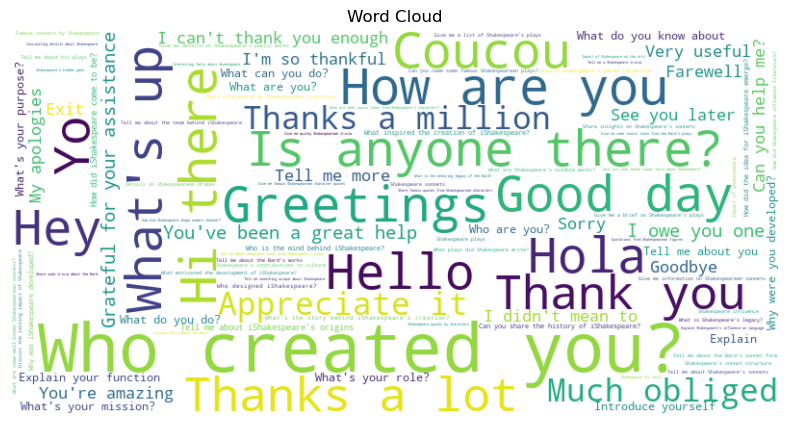

In [24]:
generate_wordcloud_from_data(data, save=True)

#### 3.2.2 Investigating the Distribution of Intents

In [169]:
def plot_intent_distribution(data: dict, save: bool = False) -> None:
    """
    Plots the distribution of intents based on the number of patterns they contain.

    Args:
        data (dict): JSON data containing intent patterns.
        save (bool, optional): Whether to save the plot as an image. Defaults has been set to False.

    
    Returns:
        None.
    Notes:
        Display the plot, and save if the argument save is set to True.
    """
    intents = [intent["tag"] for intent in data["intents"]]
    pattern_counts = [len(intent["patterns"]) for intent in data["intents"]]

    # Define colormap based on maximum and minimum pattern counts
    norm = Normalize(vmin=min(pattern_counts), vmax=max(pattern_counts))
    cmap = plt.cm.get_cmap('Reds')

    plt.figure(figsize=(10, 6))
    bars = plt.bar(intents, pattern_counts, color=cmap(norm(pattern_counts)))
    plt.xlabel('Intent')
    plt.ylabel('Number of Patterns')
    plt.title('Distribution of Intents')

    # Add color bar
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Number of Patterns')

    plt.xticks(rotation=75)
    plt.tight_layout()
    
    if save:
        plt.savefig('intent_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

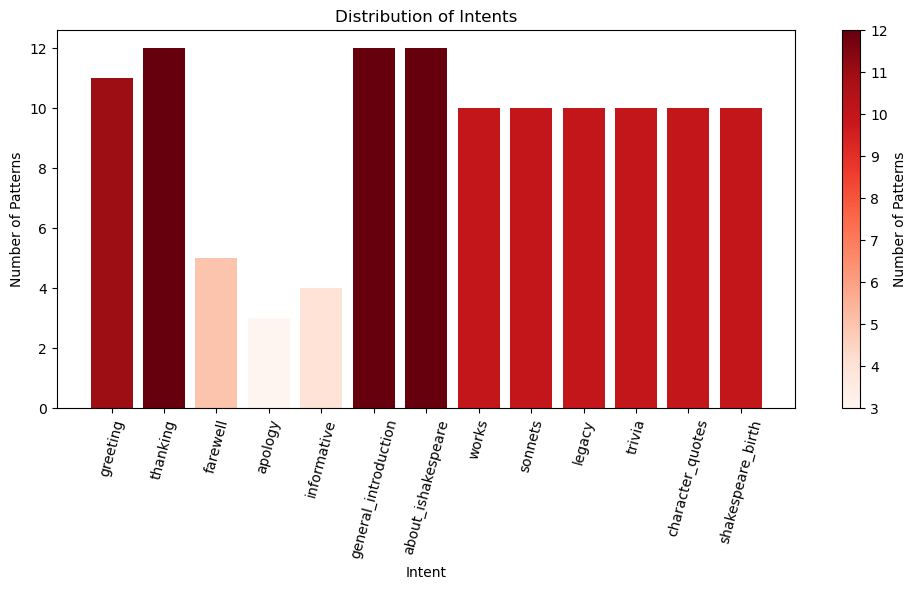

In [170]:
plot_intent_distribution(data, save=True)

In [29]:
def compute_intent_sentiment(data: dict) -> dict:
    """
    Computes the average sentiment and polarity scores for each intent based on the responses.

    Args:
        data (dict): JSON data containing intent patterns and responses.
    
    Returns:
        dict: A dictionary containing the average sentiment and polarity scores for each intent.
    """
    intent_sentiments = {}
    for intent in data["intents"]:
        responses = intent.get("responses", [])
        if responses:
            sentiment_scores = [TextBlob(response).sentiment for response in responses]
            avg_sentiment = sum(score.subjectivity for score in sentiment_scores) / len(sentiment_scores)
            avg_polarity = sum(score.polarity for score in sentiment_scores) / len(sentiment_scores)
        else:
            avg_sentiment = 0
            avg_polarity = 0
        intent_sentiments[intent["tag"]] = {"average_sentiment": avg_sentiment, "average_polarity": avg_polarity}
    return intent_sentiments


def plot_intent_sentiment(data: dict, save: bool = False) -> None:
    """
    Plots the average sentiment and polarity scores for each intent based on the responses.

    Args:
        data (dict): JSON data containing intent patterns and responses.
        save (bool, optional): Whether to save the plot as an image. Defaults to False.
    
    Returns:
        None
    """
    intent_sentiments = compute_intent_sentiment(data)

    intents = list(intent_sentiments.keys())
    avg_sentiments = [intent_sentiments[intent]["average_sentiment"] for intent in intents]
    avg_polarities = [intent_sentiments[intent]["average_polarity"] for intent in intents]

    plt.figure(figsize=(10, 6))
    plt.plot(intents, avg_sentiments, marker='o', label='Average Sentiment', color='crimson')
    plt.plot(intents, avg_polarities, marker='o', label='Average Polarity', color='dodgerblue')

    plt.xlabel('Intent')
    plt.ylabel('Score')
    plt.title('Average Sentiment and Polarity Scores for Each Intent')
    plt.xticks(rotation=65)
    plt.legend()

    if save:
        plt.savefig('intent_sentiment_scores.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

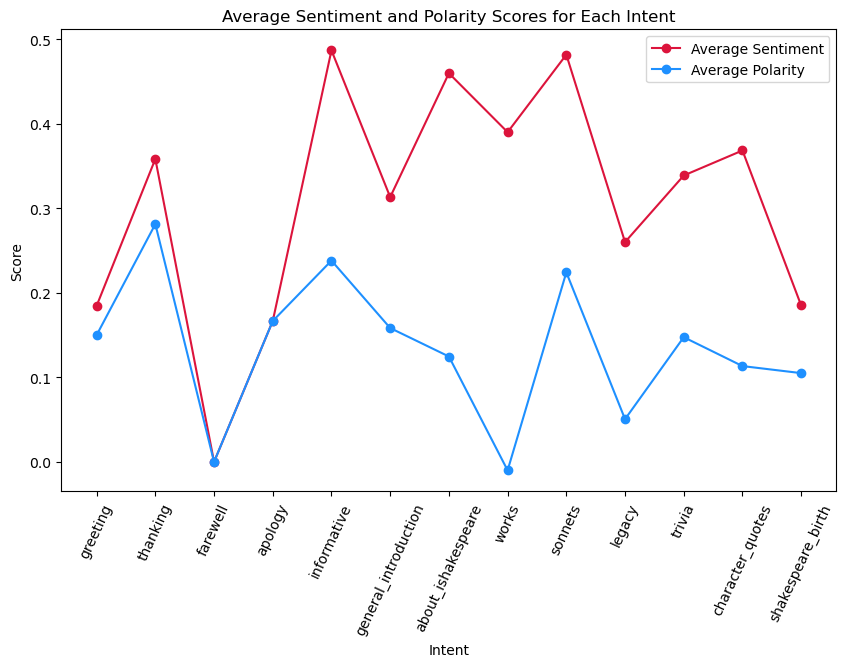

In [30]:
plot_intent_sentiment(data, True)

## 4. Model Implementation

### 4.1 Designing our Neural Network

In [172]:
class Shakespeare(nn.Module):
    def __init__(self, input_dim=None, hidden_dim=None, output_dim=None, dropout=None):
        super(Shakespeare, self).__init__()
        
        self.dropout = dropout
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = num_classes

        self.linear_relu_input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        
        
        self.linear_relu_hidden = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )
            
        self.linear_output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):

        x = self.linear_relu_input(X)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.linear_relu_hidden(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
#         x = self.linear_relu_hidden(x)
#         x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.linear_relu_hidden(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        
        x = self.linear_output(x)

        return x

In [177]:
model = Shakespeare(
    input_dim = 163,
    hidden_dim = 163,
    output_dim = num_classes,
    dropout = 0.1
).to(device)

print(model)

Shakespeare(
  (linear_relu_input): Sequential(
    (0): Linear(in_features=163, out_features=163, bias=True)
    (1): Tanh()
  )
  (linear_relu_hidden): Sequential(
    (0): Linear(in_features=163, out_features=163, bias=True)
    (1): Tanh()
  )
  (linear_output): Linear(in_features=163, out_features=13, bias=True)
)


### 4.2 Training and Validation

#### 4.2.1 Training and Validation function

In [178]:
def train_and_evaluate(
    epochs: int,
    device: torch.device,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.modules.loss,
    X: Tensor,
    y: Tensor,
    train_idx: range,
    val_idx: range
):    
    
    """
    Train and evaluate a PyTorch model.

    Args:
    - epochs (int): Number of training epochs.
    - device (torch.device): Device (e.g., 'cuda' or 'cpu') on which to perform computations.
    - model (torch.nn.Module): PyTorch model to train and evaluate.
    - optimizer (torch.optim.Optimizer): Optimization algorithm.
    - criterion (torch.nn.Module): Loss function.
    - X (torch.Tensor): Input data tensor.
    - Y (torch.Tensor): Target data tensor.
    - train_idx (range): Indices of training samples.
    - val_idx (range): Indices of validation samples.

    Returns:
    - tuple: A tuple containing the final training loss, training accuracy, validation loss, and validation accuracy.
    """
    
    pbar = tqdm(total=epochs, desc='Train', leave=False)
    model.train()

    # Move tensors to GPU if available
    X = X.to(device)
    Y = y.to(device)
    train_idx = train_idx
    val_idx = val_idx
    
    training_data = []
    
    for epoch in range(epochs):
        output = model(X)
        loss_train = criterion(output[train_idx], Y[train_idx])
        acc_train = accuracy(output[train_idx], Y[train_idx])
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output = model(X)
            loss_val = criterion(output[val_idx], Y[val_idx])
            acc_val = accuracy(output[val_idx], Y[val_idx])

        pbar.set_postfix_str('Epoch: {:04d} | [TRAIN]: loss_train: {:.4f} ; Acc_train: {:.4f} | [VALIDATION]: loss_val: {:.4f} ; acc_val: {:.4f}'.format(epoch,
                                                                                                                                                     loss_train,
                                                                                                                                                     acc_train,
                                                                                                                                                     loss_val,
                                                                                                                                                     acc_val,
                                                                                                                                                    ))
        # Append training progress to the list
        training_data.append({
            'Epoch': epoch,
            'Train_Loss': loss_train.item(),
            'Train_Acc': acc_train.item(),
            'Val_Loss': loss_val.item(),
            'Val_Acc': acc_val.item(),
        })
        
        pbar.update(1)
    
    training_df = pd.DataFrame(training_data)

    return loss_train.item(), acc_train.item(), loss_val.item(), acc_val.item(), training_df 

#### 4.2.2 Setting up the Bag of Words and the Hyperparameters

In [183]:
"""Step 1: Retrieve all unique words in the corpus"""

unique_words = []
for intent in data['intents']:
    unique_words += intent['patterns']

unique_words = unique_lemmatized_tokens(unique_words)


"""Step 2:
    (i) retrieve all labels associated to each sentences in the corpus
    (ii) generate the intent_dict (key: int, value: pattern) to be used afterwards to retrieve
         the categoriy associated to the prediction of the ANN
    (iii) generate each question under TF format (dim[0] = num_questions, dim[1] = len(unique_words))
"""

label, intent_dict, bag_of_words = generate_dataset_bag_of_words(data, unique_words)



"""Step 3: Define Train/Val/Test sets split"""

train = int(bag_of_words.shape[0] * 0.8)
val = int(bag_of_words.shape[0] * 0.1)
test = bag_of_words.shape[0] - (train + val)
train_idx, val_idx, test_idx = define_data_split(train, val, test)


"""Step 4: Convert inputs and targets to tensors and shuffle them as each sentences are in chronological order"""
X = torch.Tensor(bag_of_words)
y = torch.tensor(label).to(torch.long)

indices = torch.randperm(X.size(0))

X = X[indices]
y = y[indices]

"""Step 5: Declare all required hyperparameters"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(list(y.unique()))

input_dim, hidden_dim = bag_of_words.shape[1], bag_of_words.shape[1]


epochs = 70

lr = 0.0005

weight_decay = 0.001

# model.apply(init_weights)

model.apply(lambda x: init_weights(x, init_method='Kaimin'))


criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [184]:
loss_train, acc_train, loss_val, acc_val, training_df = train_and_evaluate(
    epochs=epochs,
    device=device,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    X=X,
    y=y,
    train_idx=train_idx,
    val_idx=val_idx
)

Train:   0%|          | 0/70 [00:00<?, ?it/s]

In [185]:
def plot_training_progress(training_data):
    """
    Plot training progress including loss and accuracy curves.

    Parameters:
    - training_data (pd.DataFrame): DataFrame containing training progress information.

    Returns:
    - None
    """
    
    # Plotting loss curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(training_data['Epoch'], training_data['Train_Loss'], label='Train Loss', marker='o', color='crimson')
    plt.plot(training_data['Epoch'], training_data['Val_Loss'], label='Val Loss', marker='o', color='dodgerblue')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(training_data['Epoch'], training_data['Train_Acc'], label='Train Accuracy', marker='o', color='crimson')
    plt.plot(training_data['Epoch'], training_data['Val_Acc'], label='Val Accuracy', marker='o', color='dodgerblue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('acc_and_loss.svg', format='svg', dpi=1200)

    plt.show()

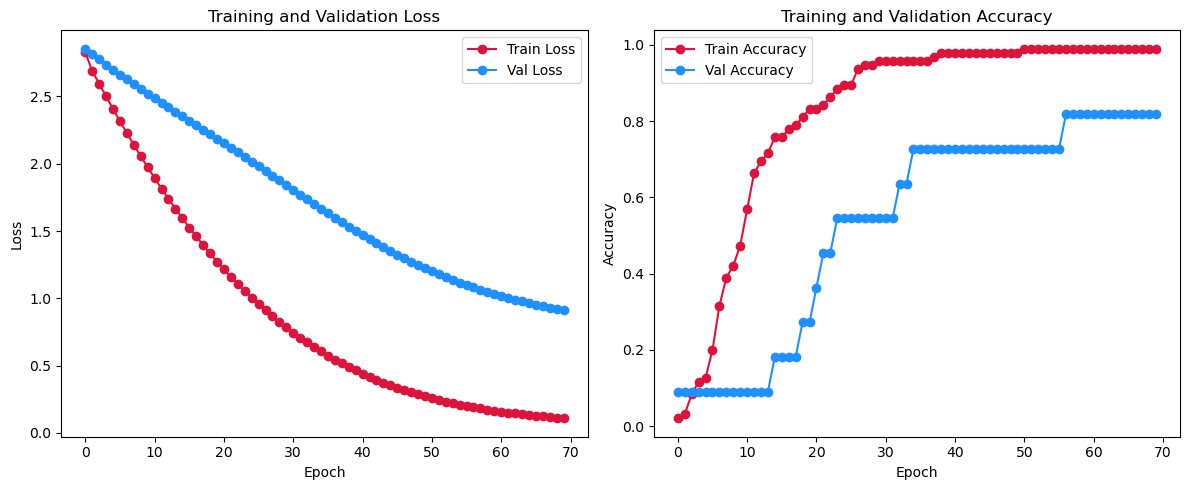

In [186]:
plot_training_progress(training_df)

### 4.3 Test Phase

In [152]:
def create_confusion_matrix(model: nn.Module,
                            test_idx: np.ndarray,
                            X: torch.Tensor,
                            y: torch.Tensor,) -> Tuple[np.ndarray, str]:
    """
    Create a confusion matrix and classification report for a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.
        test_idx (np.ndarray): Indices of the test data.
        X (torch.Tensor): Input features of the test data.
        Y (torch.Tensor): True labels of the test data.
        device (torch.device): The device to use for inference.

    Returns:
        Tuple[np.ndarray, str]: A tuple containing the confusion matrix as a numpy array
        and the classification report as a string.
    """
    model.eval()

    with torch.no_grad():
        output = model(X)
        labels = y[test_idx]
        predictions = output[test_idx].argmax(dim=1)
        acc_test = accuracy(output[test_idx], labels)

    confusion_mat = confusion_matrix(labels, predictions)
    classification_rep = classification_report(labels, predictions)
    
    print(f"\033[1mClassification Accuracy on the Test set amounts to: {acc_test.item():.2f}\033[0m")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Reds', cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return confusion_mat, classification_rep

C:\Users\leota\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leota\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leota\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\leota\anaconda3\lib\site-packages\sklearn\metrics\_cla

Classification Accuracy on the Test set amounts to: 0.62


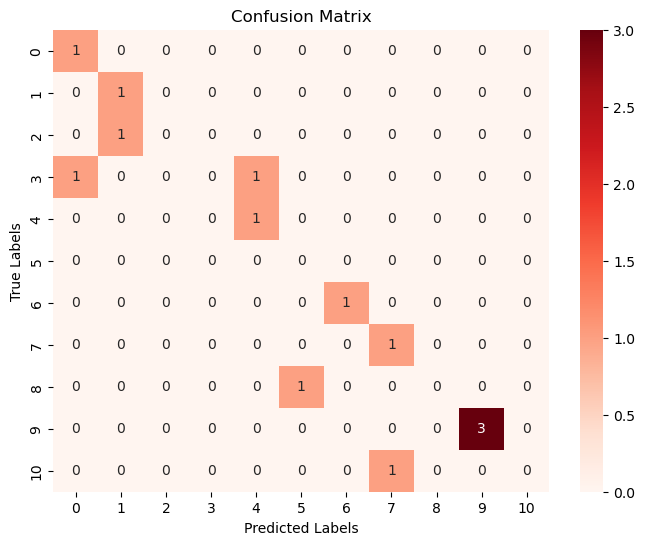

In [187]:
confusion_array, classification_rep = create_confusion_matrix(model, test_idx, X, y)

In [188]:
print(classification_rep)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.50      1.00      0.67         1
           7       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         1
           9       0.50      1.00      0.67         1
          10       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         3
          12       0.00      0.00      0.00         1

    accuracy                           0.62        13
   macro avg       0.36      0.55      0.42        13
weighted avg       0.46      0.62      0.51        13



In [189]:
"""Saving the trained model and its weights"""
torch.save(model.state_dict(), "chatbot_model.pt")

## 5. Testing the Model

In [190]:
model = Shakespeare(input_dim = 163,
                    hidden_dim = 163,
                    output_dim = num_classes,
                    dropout = 0.1
                   ).to(device)
model.load_state_dict(torch.load("chatbot_model.pt"))

<All keys matched successfully>

In [193]:
def classify_and_generate_response(model,
                                   intents_list,
                                   unique_words,
                                   sentence,
):
    
    """
    Classify the given sentence using a trained PyTorch model and generate a response.

    Parameters:
    - model (torch.nn.Module): The trained PyTorch model for classification.
    - intents_list (dict): A dictionary containing the intents and their patterns/responses.
    - unique_words (list): A list of unique words used for encoding the sentence.
    - sentence (str): The input sentence to be classified and responded to.

    Returns:
    None: Prints the generated response or a prompt for rephrasing.
    """
    
    # Set the model to evaluation mode and disable gradient computation
    model.eval()
    with torch.no_grad():
        # Convert the input sentence into a PyTorch tensor
        sentence_torch = torch.Tensor(individual_bag_of_words(sentence, unique_words))
        
        # Make a prediction using the trained model
        output = model(sentence_torch)

    # Get the predicted class and associated probability
    logit_max, predicted_class = torch.max(output, dim=0)
    soft = nn.Softmax(dim=0)
    predicted_prob = soft(logit_max).item()

    # Decode the predicted class into a string tag
    predicted_tag = predicted_class.item()
    decoded_string = intent_dict[predicted_tag]

    if predicted_prob >= 0.7:
        for intent in data['intents']:
            # Access the patterns within each intent
            if intent['tag'] == decoded_string:
                possible_answers = intent['responses']
                aleatoric_answer_idx = random.randint(0, len(possible_answers) - 1)
                final_answer = possible_answers[aleatoric_answer_idx]
                return str(final_answer)
    else:
        return 'May I please ask you to rephrase your query ?'

In [198]:
user_prompt = input("\033[1m" + "You" + "\033[0m" + ": ")
x = classify_and_generate_response(model, data, unique_words, user_prompt)
print("\033[1m" + "iShakespeare" + "\033[0m" + ": " + x)

while user_prompt!= 'exit': 
    user_prompt = input("\033[1m" + "You" + "\033[0m" + ": ")
    x = classify_and_generate_response(model, data, unique_words, user_prompt)
    print("\033[1m" + "iShakespeare" + "\033[0m" + ": " + str(x))
    
    if user_prompt == 'exit':
        x = data["intents"][2]["responses"][0]  # Select the response from the farewell category
        print("\033[1m" + "iShakespeare" + "\033[0m" + ": " + x)
        break

You: Hello
iShakespeare: Hola! How may I assist you?
You: Who are you?
iShakespeare: My mission is to assist and educate users about the life and works of William Shakespeare.
You: Tell me something about Shakespeare then
iShakespeare: Shakespeare's exact birthdate is unknown, but it is traditionally celebrated on April 23, the same day as his death.
You: What is Shakespeare's most famous play ?
iShakespeare: Some of Shakespeare's notable plays include 'Romeo and Juliet,' 'Hamlet,' 'Macbeth,' 'Othello,' 'King Lear,' and 'A Midsummer Night's Dream.' Each play explores different themes and genres, showcasing Shakespeare's versatility as a playwright.
You: exit
iShakespeare: Phrases and expressions coined by Shakespeare are still in common use today, demonstrating his enduring influence on the English language.
iShakespeare: Goodbye!
